In [12]:
import altair as alt

# This is to enable visualization rendering inside the notebook,
# similar to the inline instruction from matplotlib.
# NOTE: if you're using 
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

### The simplest way to reproduce the visualization from Lab 7 is to import the JSON that we generated with vega-lite and feed it to Altair.

In [2]:
# Here I just copy the JSON, and store it to task1_json.
# You could also directly fetch it from URL 
lab7_json = """
{
  "$schema": "https://vega.github.io/schema/vega-lite/v2.json",
  "data": {
    "url": "https://raw.githubusercontent.com/hvo/datasets/master/nyc_restaurants_by_cuisine.json",
    "format": { "type": "json" }
  },
  "transform": [
    {"filter": "datum._vgsid_<=25"}
  ],
  "selection": {
    "search": {
      "bind": {
        "input": "input"
      },
      "empty": "none",
      "on": "mouseover",
      "fields": ["term"],
      "type": "single"
    },
    "highlight": {
      "type": "single",
      "on": "mouseover",
      "empty": "none"
    }
  },
  "mark": {
    "type": "bar",
    "stroke": "black"    
  },
  "encoding": {
    "color": {
      "condition": {
        "test": "(indexof(lower(datum.cuisine), lower(search.term))>=0) || (highlight._vgsid_==datum._vgsid_)",
        "value": "SteelBlue"
      },
      "value": "LightGrey"
    },
    "y": {
      "field": "cuisine",
      "type": "ordinal",
      "sort": {"field": "total", "op": "argmax"}
    },
    "x": {
      "field": "total",
      "type": "quantitative",
      "axis": {
      "title": "Restaurants"
      }
    }
  }
}
"""

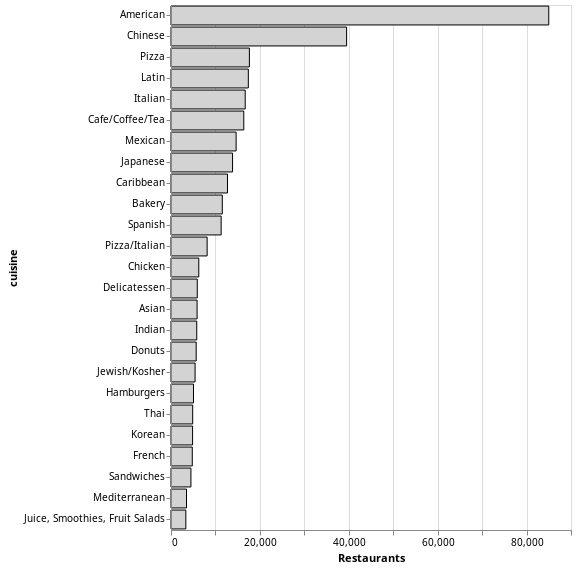

In [3]:
# Then we just create a chart using this JSON
alt.Chart.from_json(lab7_json)

Note that each visualization in Altair is a one-to-one mapping to a Vega-lite JSON, which can also be exported to the online editor. Though the above works okay, but it doesn't give us any benefit of using Python. Next, we're looking at how to build a similar pipeline purely in Python's idiom. To create a visualization, we can start with a data source, marks and encondings. Here we specify both the names of the fields, their types using shorthand form:

`FIELD_NAME:TYPE_INITIAL`

where `TYPE_INITIAL` can be (**Q**)uantitative, (**O**)rder, etc. The output of the cell below is our very first plot in Task 1, completely unfiltered.


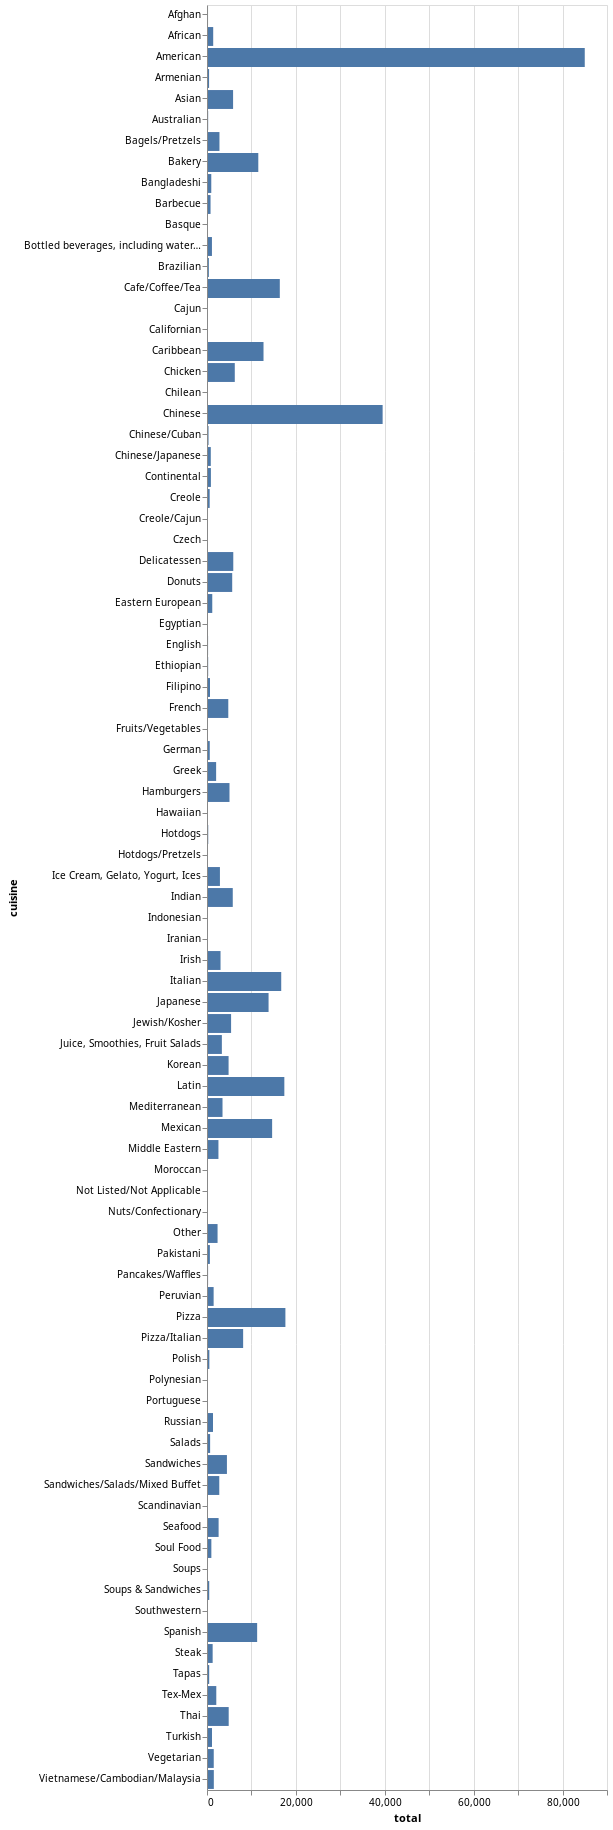

In [4]:
RESTAURANT_URL = "https://raw.githubusercontent.com/hvo/datasets/master/nyc_restaurants_by_cuisine.json"
alt.Chart(alt.UrlData(RESTAURANT_URL)) \
    .mark_bar() \
    .encode(
        x="total:Q",
        y="cuisine:O",
    )

Next, let's add styling to our plot using the color and sort the fields. For those, we can add **stroke**'s style directly to the ```mark_bar()```, and create a full scale encoding (aka. more than just specifying a shorthand) for X, Y, and the color channel.

Since we are using ```altair.X``` and ```altair.Y``` for our encoding, we don't have to explicitly specify ```x=...``` or ```y=...``` in the ```encode()``` function anyomre.

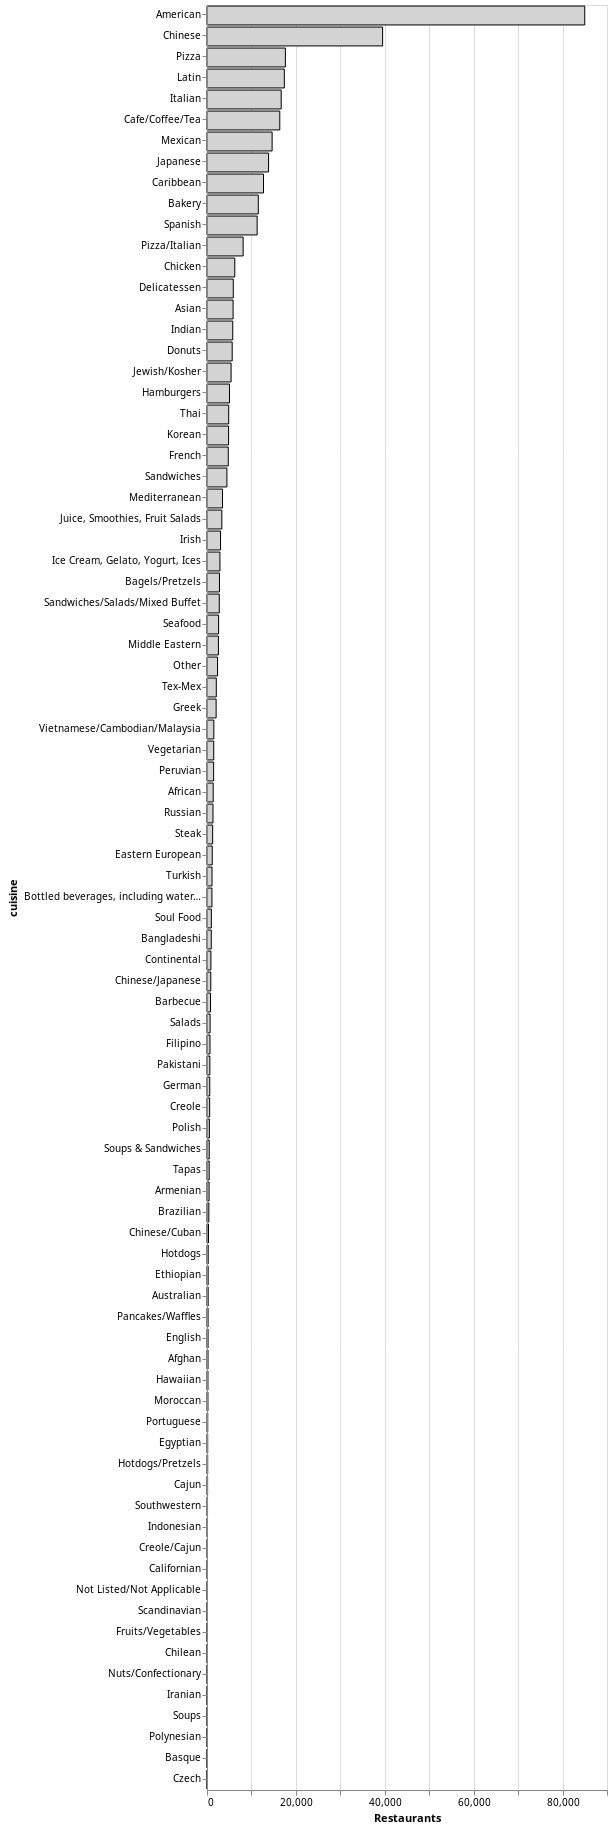

In [13]:
RESTAURANT_URL = "https://raw.githubusercontent.com/hvo/datasets/master/nyc_restaurants_by_cuisine.json"
alt.Chart(alt.UrlData(RESTAURANT_URL)) \
    .mark_bar(stroke="Black") \
    .encode(
        alt.X("total:Q", axis=alt.Axis(title="Restaurants")),
        alt.Y('cuisine:O', sort=alt.EncodingSortField(field="total", op="argmax")),
        alt.ColorValue("LightGrey"),
    )

We are ready to add back selection, and keep only the top 25 items using ```transform_filter```. Since selections are part of properties, we add them through the ```properties()``` function. We will also add our simple highlighting by linking the selection with our color channel through ```condition```. For this type of selection condition, we use ```ConditionalSelectionValueDef```. All of our parameters stay the same as in Lab 7, they are just passed along to Altair as keyword arguments, instead of a JSON data.

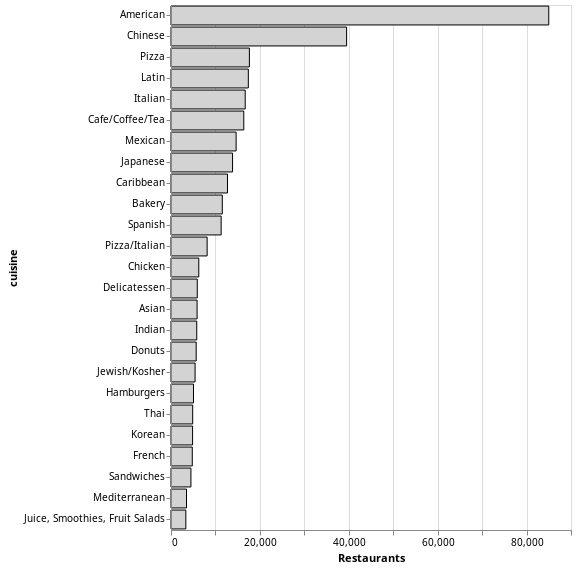

In [14]:
RESTAURANT_URL = "https://raw.githubusercontent.com/hvo/datasets/master/nyc_restaurants_by_cuisine.json"
alt.Chart(alt.UrlData(RESTAURANT_URL)) \
    .mark_bar(stroke="Black") \
    .encode(
        alt.X("total:Q", axis=alt.Axis(title="Restaurants")),
        alt.Y('cuisine:O', sort=alt.EncodingSortField(field="total", op="argmax")),
        alt.ColorValue("LightGrey", 
                       condition=alt.ConditionalSelectionValueDef("highlight", "SteelBlue")),
    ).properties(
        selection=alt.selection_single(name="highlight", on="mouseover", empty="none"),
    ).transform_filter('datum._vgsid_<=25')    

Finally, we add our **search** selection. In JSON, we can stack up selections by adding another entry to the selection object in JSON. In Altair, selection is already a mapping, we can stack them together by just "adding" them through the **"+"** operator. Binding in Altair must be done through the ```VgGenericBinding``` class instead of freely specifying in a text description.

With the new selection, we need to perform the keyword filter. Since this is a different type of conditional, i.e. a predicate, we need to replace the ```ConditionalSelectionValueDef``` with the ```ConditionalPredicateValueDef```, wheer we will use our original test predicate in Lab 7. The following should reproduce the complete visualization in Lab 7.

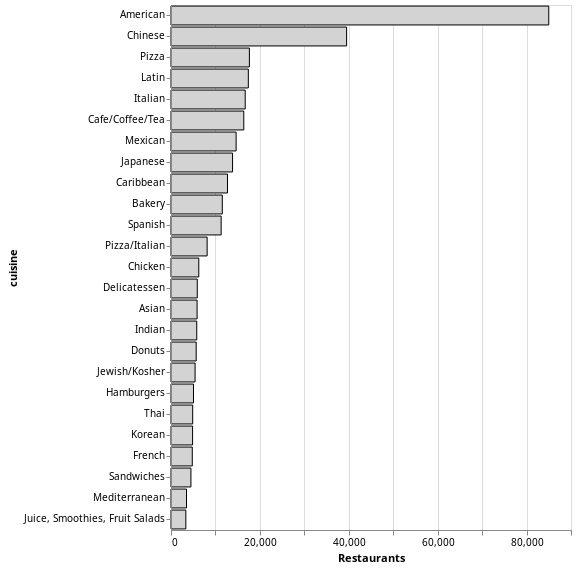

In [16]:
RESTAURANT_URL = "https://raw.githubusercontent.com/hvo/datasets/master/nyc_restaurants_by_cuisine.json"
alt.Chart(alt.UrlData(RESTAURANT_URL)) \
    .mark_bar(stroke="Black") \
    .encode(
        alt.X("total:Q", axis=alt.Axis(title="Restaurants")),
        alt.Y('cuisine:O', sort=alt.EncodingSortField(field="total", op="argmax")),
        alt.ColorValue("LightGrey", 
                       condition=alt.ConditionalPredicateValueDef(
                           "(indexof(lower(datum.cuisine), search.term)>=0) || (highlight._vgsid_==datum._vgsid_)", 
                           "SteelBlue")
                      ),
    ).properties(
        selection=(alt.selection_single(name="highlight", on="mouseover", empty="none") +
                   alt.selection_single(name="search", on="mouseover", empty="none", fields=["term"],
                                        bind=alt.VgGenericBinding('input'))),
    ).transform_filter('datum._vgsid_<=25')    

Though everything can be put in a single call with Altair, in practice, it might be more readable to define complex components up front to make it easier to understand the pipeline. Below is an example.

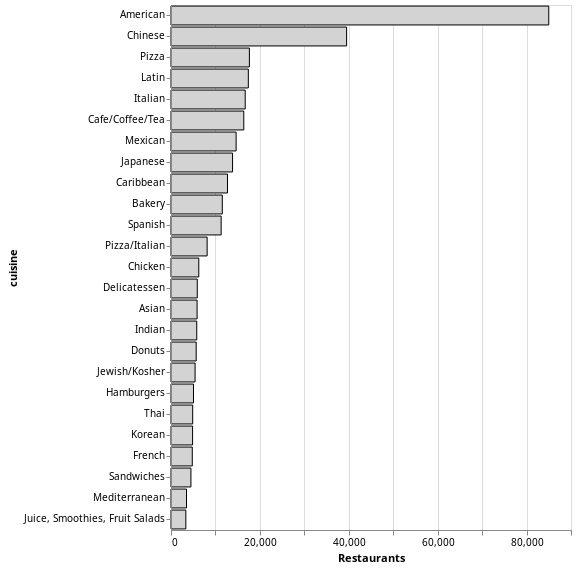

In [17]:
RESTAURANT_URL      = "https://raw.githubusercontent.com/hvo/datasets/master/nyc_restaurants_by_cuisine.json"
color_expression    = "(indexof(lower(datum.cuisine), search.term)>=0) || (highlight._vgsid_==datum._vgsid_)"
color_condition     = alt.ConditionalPredicateValueDef(color_expression, "SteelBlue")
highlight_selection = alt.selection_single(name="highlight", on="mouseover", empty="none")
search_selection    = alt.selection_single(name="search", on="mouseover", empty="none", fields=["term"],
                                           bind=alt.VgGenericBinding('input'))
alt.Chart(alt.UrlData(RESTAURANT_URL)) \
    .mark_bar(stroke="Black") \
    .encode(
        alt.X("total:Q", axis=alt.Axis(title="Restaurants")),
        alt.Y('cuisine:O', sort=alt.EncodingSortField(field="total", op="argmax")),
        alt.ColorValue("LightGrey", condition=color_condition),
    ).properties(
        selection=(highlight_selection + search_selection),
    ).transform_filter('datum._vgsid_<=25')    

We have now completely recreated the pipeline in Lab 7 using Altair. However, we still employ the trick of using the selection id ```_vgsid_``` to do our filter. This might not work if we have a more complex filtering mechanism. Using Python, we could filter the data before it reaches the visualization. In particular, we can do the following (note the ```data``` variable). We can then remove the ```transform_filter``` at the end.

In [18]:
import pandas as pd

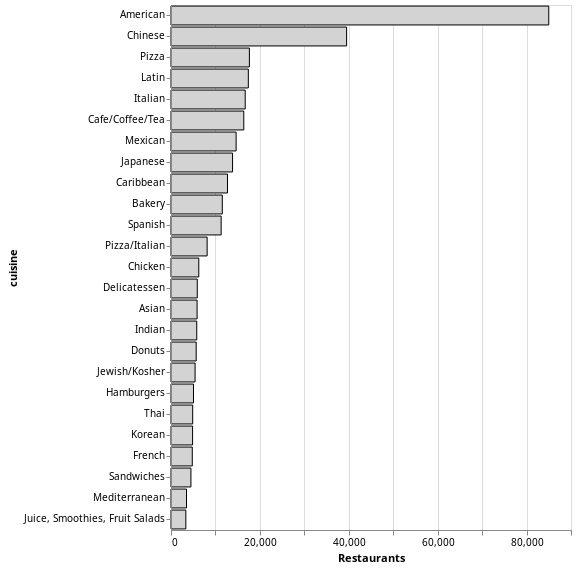

In [19]:
RESTAURANT_URL      = "https://raw.githubusercontent.com/hvo/datasets/master/nyc_restaurants_by_cuisine.json"
data                = pd.read_json(RESTAURANT_URL).sort_values(by=['total'], ascending=False)[:25]
color_expression    = "(indexof(lower(datum.cuisine), search.term)>=0) || (highlight._vgsid_==datum._vgsid_)"
color_condition     = alt.ConditionalPredicateValueDef(color_expression, "SteelBlue")
highlight_selection = alt.selection_single(name="highlight", on="mouseover", empty="none")
search_selection    = alt.selection_single(name="search", on="mouseover", empty="none", fields=["term"],
                                           bind=alt.VgGenericBinding('input'))
alt.Chart(data) \
    .mark_bar(stroke="Black") \
    .encode(
        alt.X("total:Q", axis=alt.Axis(title="Restaurants")),
        alt.Y('cuisine:O', sort=alt.EncodingSortField(field="total", op="argmax")),
        alt.ColorValue("LightGrey", condition=color_condition),
    ).properties(
        selection=(highlight_selection + search_selection),
    )    

There is no visual difference between the two approaches. However if you export the visualization to JSON (by clicking on View Source), you will see that the later approach (that uses pandas) will include all filtered data points in the specification. Though that works, it sometime pollute your visualization if you care much about exporting your visualization.

Next, we look at how to export our visualizations to HTML and JSON in Altair. First, just putting everything together here. We store the two visualizations into ```vis1``` and ```vis2``` for the selection-workaround, and the pandas approach, respectively. 

In [21]:
RESTAURANT_URL      = "https://raw.githubusercontent.com/hvo/datasets/master/nyc_restaurants_by_cuisine.json"
data                = pd.read_json(RESTAURANT_URL).sort_values(by=['total'], ascending=False)[:25]
color_expression    = "(indexof(lower(datum.cuisine), search.term)>=0) || (highlight._vgsid_==datum._vgsid_)"
color_condition     = alt.ConditionalPredicateValueDef(color_expression, "SteelBlue")
highlight_selection = alt.selection_single(name="highlight", on="mouseover", empty="none")
search_selection    = alt.selection_single(name="search", on="mouseover", empty="none", fields=["term"],
                                           bind=alt.VgGenericBinding('input'))

vis1 = alt.Chart(alt.UrlData(RESTAURANT_URL)) \
    .mark_bar(stroke="Black") \
    .encode(
        alt.X("total:Q", axis=alt.Axis(title="Restaurants")),
        alt.Y('cuisine:O', sort=alt.EncodingSortField(field="total", op="argmax")),
        alt.ColorValue("LightGrey", condition=color_condition),
    ).properties(
        selection=(highlight_selection + search_selection),
    ).transform_filter('datum._vgsid_<=25')

vis2 = alt.Chart(data) \
    .mark_bar(stroke="Black") \
    .encode(
        alt.X("total:Q", axis=alt.Axis(title="Restaurants")),
        alt.Y('cuisine:O', sort=alt.EncodingSortField(field="total", op="argmax")),
        alt.ColorValue("LightGrey", condition=color_condition),
    ).properties(
        selection=(highlight_selection + search_selection),
    )    

To export a visualization to JSON, we can just call ```to_json()``` function. Altair also provides a function to export to HTML, named ```to_html()```, where it takes care of the ```vega-embed``` step that we did in Lab 7. In addition, exporting to HTML in Altair also put both the JSON specifications and HTML together in a single file (instead of two as we did before). You can take that file and put to GIST, or view locally.

In [26]:
print(vis1.to_json())

{
  "$schema": "https://vega.github.io/schema/vega-lite/v2.6.0.json",
  "config": {
    "view": {
      "height": 300,
      "width": 400
    }
  },
  "data": {
    "url": "https://raw.githubusercontent.com/hvo/datasets/master/nyc_restaurants_by_cuisine.json"
  },
  "encoding": {
    "color": {
      "condition": {
        "test": "(indexof(lower(datum.cuisine), search.term)>=0) || (highlight._vgsid_==datum._vgsid_)",
        "value": "SteelBlue"
      },
      "value": "LightGrey"
    },
    "x": {
      "axis": {
        "title": "Restaurants"
      },
      "field": "total",
      "type": "quantitative"
    },
    "y": {
      "field": "cuisine",
      "sort": {
        "field": "total",
        "op": "argmax"
      },
      "type": "ordinal"
    }
  },
  "mark": {
    "stroke": "Black",
    "type": "bar"
  },
  "selection": {
    "highlight": {
      "empty": "none",
      "on": "mouseover",
      "type": "single"
    },
    "search": {
      "bind": {
        "input": "input"
    

In [23]:
vis1.save('DV_Lab8_Altair.html')

In [24]:
#print(open('DV_Lab8_Altair.html', 'r').read())

### For the second approach, the JSON will include all the data!
The output is omitted here to save space.

In [25]:
#print(vis2.to_json())

## <font color='red'>**TURN IN:** Please save ```vis2``` to an HTML file and upload that to your GIST as ```index.html```. Then turn in your bl.ocks.org link to that GIST, similar to what we did in Lab 7.</font>